# Introduction

**Gradcafe** is a platform where grad school applicants share admission status and communicate updates. One thing all applicants need is information - when to expect an interview, whether being put in a waiting list or receiving an email starting with Congratulations. The uncertainty that comes with these questions can be relieved to certain degree with information from other applicants.

As freshly admitted grad students, we are curious what we can know about application in Statistics over the last decade from **Gradcafe**, where we have access to 10,000 application results from 2010 to 2020 with information on the program, year, applicant undergrad GPA, GRE result, admission status, etc.

We also incorporate two major university rankings in Statistics: **US News** and **QS World University Rankings** as these rankings are reliable indicators of academic reputation of a particular university and program, which can affect decisions of both applicants and programs significantly. Besides, these two rankings are selected to represent the major domestic and international evaluation of universities.

With three datasets on admission result and ranking scraped, we are able to answer two major questions below.
1. What kind of programs are popular among the applicants in Statistics?
2. What kind of applicants are usually preferred by Statistics graduate programs?

# Exploratory Data Analysis

We first conducted exploratory data analysis on the Gradcafe dataset and got some prelimitary findings about applicants in Statistics.

In [1]:
from plot_functions import *
df.head()

,institution,program,degree,season,admission_status,admission_via,admission_date,ST,Date_added,notes,Undergrad_GPA,GRE_V,GRE_Q,GRE_W,GRE_sub,USnew_stat_score,USnew_overall_score
0,Iowa State University (Department of Statistics),Statistics,PhD,F20,Wait listed,Website,2020-03-08,U,2020-03-08,Expected,NaN,NaN,NaN,NaN,NaN,3.8,61.0
1,Texas A&M University--College Station (Departm...,Statistics,PhD,F20,Other,Other,2020-03-08,O,2020-03-08,To the poster below: Is the funding for 9 mont...,NaN,NaN,NaN,NaN,NaN,3.8,66.2
2,University of Massachusetts--Amherst (Departme...,Statistics,PhD,F20,Other,Other,2020-03-08,O,2020-03-08,Has anyone heard anything yet?,NaN,NaN,NaN,NaN,NaN,2.5,66.1
3,University of Massachusetts--Amherst (Departme...,Statistics,PhD,F20,Other,Other,2020-03-08,O,2020-03-08,Has anyone heard anything yet?,NaN,NaN,NaN,NaN,NaN,2.5,66.1
4,Florida State University (Department of Statis...,Statistics,PhD,F20,Accepted,E-mail,2020-03-08,I,2020-03-07,"I'm admitted on March 4, and the funding decis...",NaN,NaN,NaN,NaN,NaN,3.1,62.3


## What is the most popular Statistics PhD program?
We show counts of reports on each school.

In [2]:
df.loc[df["degree"]=="PhD"]["institution"].value_counts().head(20)

Carnegie Mellon University (Department of Statistics)                  332
North Carolina State University--Raleigh (Department of Statistics)    310
University of Washington (Department of Statistics)                    288
University of Michigan--Ann Arbor (Department of Statistics)           282
University of Chicago (Department of Statistics)                       261
Duke University (Department of Statistical Science)                    215
University of California--Berkeley (Department of Statistics)          212
University of Wisconsin--Madison (Department of Statistics)            208
Columbia University (Department of Statistics)                         192
Pennsylvania State University (Department of Statistics)               168
Harvard University (Department of Statistics)                          163
University of Illinois--Urbana-Champaign (Department of Statistics)    163
Cornell University (Department of Statistical Science)                 162
Stanford University (Depa

## Compare GPA grouped by different degrees
We created a density plot of applicants' GPA by degree, whether it is a doctoral, master's, or other program.

It can be noticed that most applicants of doctoral degree on Gradcafe have a GPA over 3.5, and applicants mostly have a GPA close to 4, while the density of applications with such high GPA is much smaller for a master's degree in Statistics, which is approx. 1.7.

Therefore, we can conclude that applicants of doctoral program generally have a higher GPA than applicants of master's program, which also indicates that Statistics doctoral program is generally more competitive and demanding than a master's program.

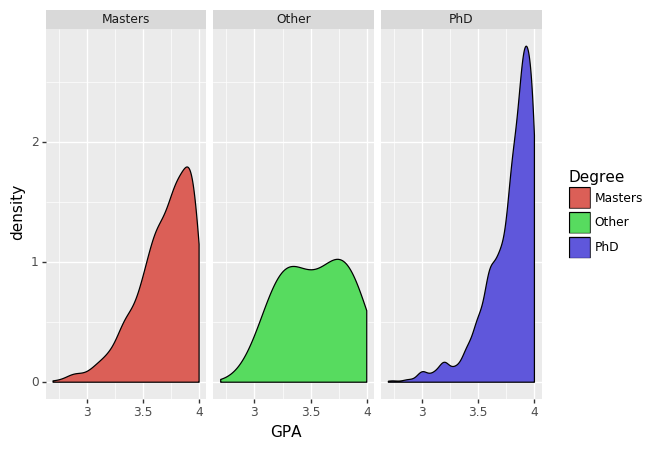

<ggplot: (170538366433)>

In [3]:
# GPA by degree
gg = p9.ggplot(df[~pd.isna(df.Undergrad_GPA)], p9.aes(x='Undergrad_GPA', fill='degree'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Degree')
gg += p9.facet_wrap('~degree')
gg += p9.labs(x='GPA')
gg
# As expected, PhD applicants have much higher GPA

## Compare GPA grouped by different student pools

We created four density plots of applicants' GPA by locations of applicants' undergraduate institution and nationality: whether applicants received a degree from U.S. or international institution, and whether the applicant is U.S. citizen or not.

Most applicants have a GPA over 3.5 across all four locations, though the number is particularly high for international applicants with a U.S. degree where most applicants have a GPA around 3.9. However, the general distribution for all four locations is similar and there is no significant difference across locations.

It worths noticing that different institutions have different GPA systems and policies: some insitutions and programs tend to have a more strict grading policy than others.

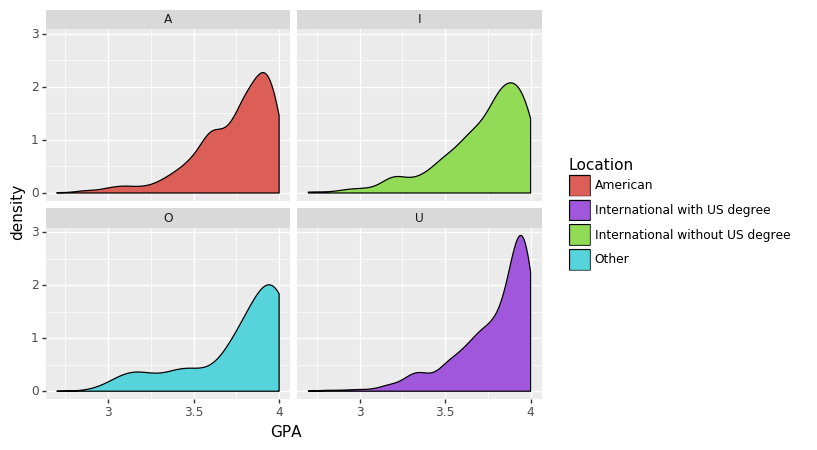

<ggplot: (170540663062)>

In [5]:
# GPA by location
loc = ['American', 'International with US degree', 'International without US degree', 'Other']

gg = p9.ggplot(df[(~pd.isna(df.Undergrad_GPA))&(~pd.isna(df.ST))], p9.aes(x='Undergrad_GPA', fill='ST'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GPA')
gg
# International students with US degree tend to have higher GPA

## GRE by different student pools

GRE score is another important indicator of applicant competency and mostly required by Statistics postgraduate programs. GRE score constitutes three parts: quantitative, verbal, and analytical writing. We created four density plots of applicants' GRE by locations of applicants' undergraduate institution and nationality.


### GRE: Analytical Writing

As expected, Americans generally have higher analytical writing scores than international students; international students with a U.S. degree tend to have higher scores than those without a U.S. degree. This conclusion makes sense as analytical writing is conducted in English; applicants with U.S. degree or are native speakers should achieve higher score in this section.

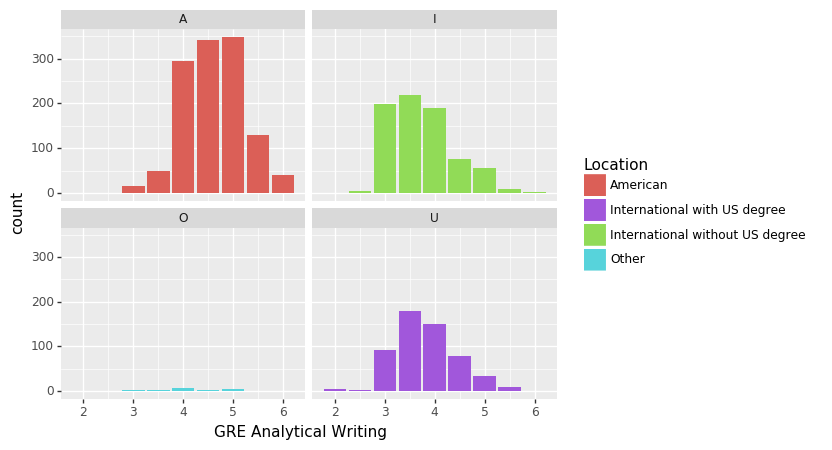

<ggplot: (-9223371866312929399)>

In [6]:
# GRE AW by location

gg = p9.ggplot(df[(~pd.isna(df.GRE_W))&(~pd.isna(df.ST))], p9.aes(x='GRE_W', fill='ST'))
gg += p9.geom_col(stat='count')
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GRE Analytical Writing')
gg
# International students without US degree tend to have lower GRE AW

### GRE: Verbal
We can see a similar distribution as in analytical writing, where verbal score is highly related with English language capability. Since some applicants did not report their location on Gradcafe, we have an abnormal distribution for applicants with other location.

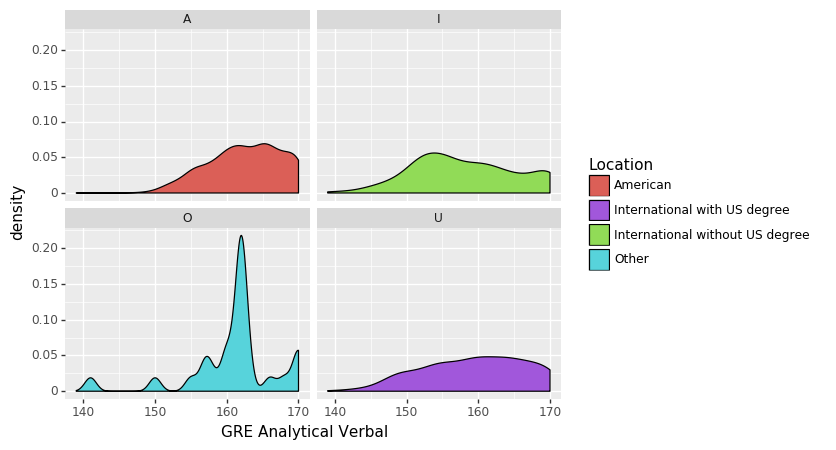

<ggplot: (-9223371944455992300)>

In [12]:
# GRE V by location

gg = p9.ggplot(df[(~pd.isna(df.GRE_V))&(~pd.isna(df.ST))], p9.aes(x='GRE_V', fill='ST'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GRE Analytical Verbal')
gg
# International students without US degree tend to have lower GRE V

### GRE: Quantitative
For quantitative section, international applicants tend to have a close-to-perfect score, which is much higher than that of American applicants and international applicants with a U.S. degree.

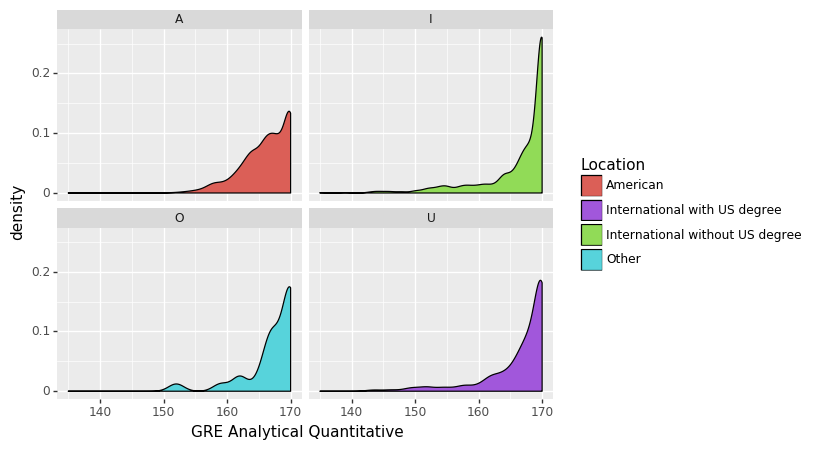

<ggplot: (-9223371944455300148)>

In [13]:
# GRE Q by location

gg = p9.ggplot(df[(~pd.isna(df.GRE_Q))&(~pd.isna(df.ST))], p9.aes(x='GRE_Q', fill='ST'))
gg += p9.geom_density()
gg += p9.scale_fill_discrete(name='Location',breaks=['A', 'U', 'I', 'O'] , labels=loc)
gg += p9.facet_wrap('~ST')
gg += p9.labs(x='GRE Analytical Quantitative')
gg
# International students without US degree tend to have higher GRE Q

## Average timeline of admission decisions
We compare the timelines of different institutions in terms of making decisions on PhD admission. This is presented by yearly aggregated counts of events. For example, we compare **UC Davis** and **Stanford**.

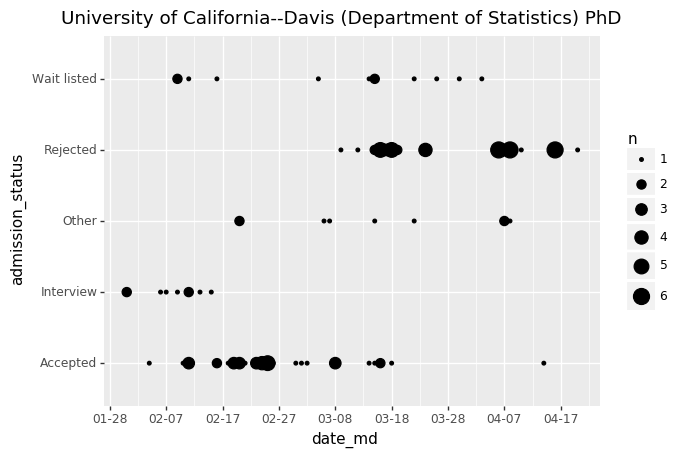

<ggplot: (-9223371866312810913)>

In [7]:
event_counts_date({"institution": "Davis", "degree": "PhD"})

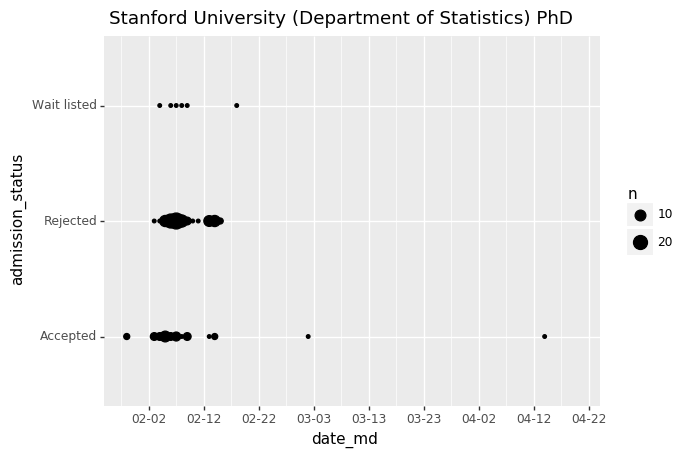

<ggplot: (-9223371866312575919)>

In [8]:
event_counts_date({"institution": "Stanford", "degree": "PhD"})

We see that Stanford is considerably earlier in terms of making decisions on admissions and rejections. Most of their decisions are made before the middle of Feburary, when UC Davis is still beginning to interview applicants and give offers. Another interesting fact is that Stanford seems to never interview applicants.

After comparing more timelines of different schools, we find that schools with higher ranking tend to make decisions earlier. This fact is consistent with our common sense.

## Which school is the hardest to get in?
Although this dataset from Gradcafe can only represent part of the applicants, it's nevertheless interesting to compare the acceptance rate among all applicants of different programs, which we believe would partially reflectculty of applyininthis program. 

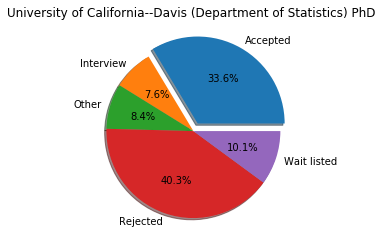

In [9]:
prop_piechart("admission_status", {
                  "institution": "Davis", "degree": "PhD"})

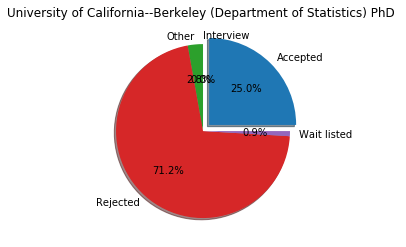

In [10]:
prop_piechart("admission_status", {
                  "institution": "Berkeley", "degree": "PhD"})

Comparing UC Davis and Berkeley, the rejection rate of Berkeley is considerably higher. Berkeley ranks top 2 in Statistics subject according to USnews, and it is very difficult to get in.

We can see which school has the lowest admission rate of Stats PhD, by an naively estimate--the count of admission divided by the sum of the counts of admission and rejection.

In [11]:
def summary_admission_prop(x):
    t = x["admission_status"].value_counts()
    return t["Accepted"] / (t["Accepted"] + t["Rejected"])
(df.loc[df["degree"] == "PhD"]).groupby(
    "institution").apply(summary_admission_prop).sort_values()[df["institution"].value_counts() >= 100]

institution
Duke University (Department of Statistical Science)                                           0.176829
University of Pennsylvania (Department of Statistics)                                         0.191667
Harvard University (Department of Statistics)                                                 0.217687
Yale University (Department of Statistics)                                                    0.246914
University of California--Berkeley (Department of Statistics)                                 0.259804
Columbia University (Department of Statistics)                                                0.262411
Cornell University (Department of Statistical Science)                                        0.276596
University of Washington (Department of Statistics)                                           0.277108
Stanford University (Department of Statistics)                                                0.277778
Carnegie Mellon University (Department of Statistics)        

However, we should keep in mind that this dataset may be a biased sample, or in other words, missing not at random. For example, people may be more likely to report their acceptance than to report rejection on Gradcafe. Therefore, we expect this acceptance rate to be an overestimate--You will not believe OSU accept 77% of all applicants each year!

## Proportion of International Student
As PhDs in Statistics in UC Davis, we found the proportion of international students in our department to be particularly high. Is this also true for other schools?

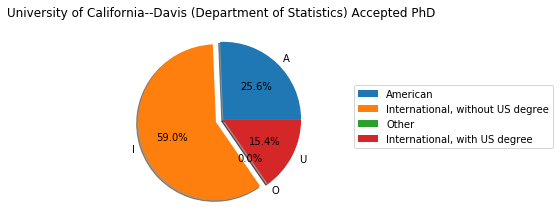

In [13]:
prop_piechart("ST", {"institution": "Davis",
                         "admission_status": "Accepted", "degree": "PhD"})

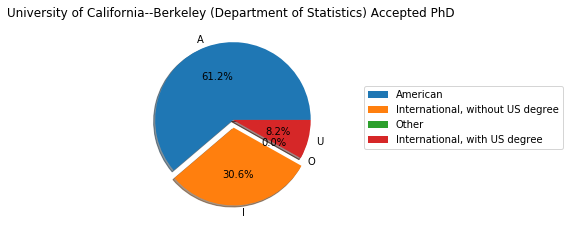

In [14]:
prop_piechart("ST", {"institution": "Berkeley",
                         "admission_status": "Accepted", "degree": "PhD"})

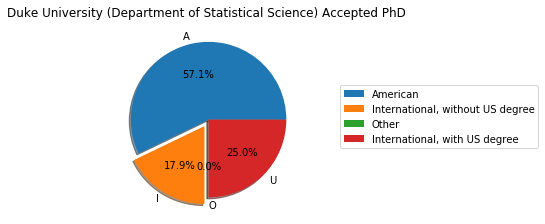

In [15]:
prop_piechart("ST", {"institution": "Duke",
                         "admission_status": "Accepted", "degree": "PhD"})

We found that many other schools, e.g. Duke and UC Berkeley, do not have so many international PhDs as in UC Davis Statistics.

We can have a look at which school prefers international students most in terms of PhD in Statistics.

In [17]:
def summary_ST_prop(x):
    t = x["ST"].value_counts()
    return t["I"]/np.sum([t[i] for i in t.index])
(df.loc[(df["admission_status"] == "Accepted") & (df["degree"] == "PhD")]).groupby(
        "institution").apply(summary_ST_prop).sort_values(ascending=False)[df["institution"].value_counts() >= 100]

institution
University of Florida (Department of Statistics)                                              0.660000
Stanford University (Department of Statistics)                                                0.625000
Columbia University (Department of Statistics)                                                0.621622
University of California--Davis (Department of Statistics)                                    0.589744
Harvard University (Department of Statistics)                                                 0.566667
University of Chicago (Department of Statistics)                                              0.527027
Yale University (Department of Statistics)                                                    0.526316
University of Pennsylvania (Department of Statistics)                                         0.500000
University of Minnesota--Twin Cities (School of Statistics)                                   0.479167
University of Michigan--Ann Arbor (Department of Statistics) 

Still, we need to point out that this dataset may be a biased sample of the whole applicants. We believe that the proportion of international students in this dataset is likely to be underestimated, because many international students do not report on Gradcafe (they do not even know this website).

## Decision Tree Classifier

**Response**

*admission_status*: Accepted, Rejected, Other

**Predictors**

*degree*: Masters, PhD

*admission_via*: E-mail, Other, Website

*ST* (source of students): I, A, U

*Undergrad_GPA*, *GRE_V*, *GRE_Q*, *GRE_W*, *GRE_sub*, *USnew_stat_score*, *USnew_overall_score*

**Steps**

1. encode categorical features (*degree*, *admission_via*, *ST*) as a one-hot numeric array.
2. split dataset into random train and test subsets.
3. train decision tree classifier and post prune decision trees with cost complexity pruning.

In [421]:
# alternate OneHotEncoder

from sklearn import tree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

df = df.dropna()
X = df[['degree', 'ST', 'Undergrad_GPA', 'GRE_V', 'GRE_Q', 'GRE_W', 'GRE_sub', 'USnew_stat_score', 'USnew_overall_score']]
y = df.admission_status
categorical_feature_mask = X.dtypes=='category'
ohe = ColumnTransformer(
    transformers=[
        ("OneHot",        # Just a name
         OneHotEncoder(), # The transformer class
         categorical_feature_mask # The column(s) to be applied on
        )
    ], remainder='passthrough' # donot apply anything to the remaining columns
)
X_ohe = ohe.fit_transform(X) # It returns an numpy array
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import plotnine as p9

In [444]:
%run "../code/clean"

In [445]:
# data preprocessing
# merge some categories
df.loc[df.admission_status=='Wait listed', 'admission_status'] = 'Other'
df.loc[df.admission_status=='Interview', 'admission_status'] = 'Other'
df.loc[df.degree=='Other', 'degree'] = 'Masters'
df.loc[df.admission_via=='Postal Service', 'admission_via'] = 'Other'
df.loc[df.admission_via=='Phone', 'admission_via'] = 'Other'
df.loc[df.ST=='O', 'ST'] = 'I'

In [446]:
import graphviz
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

df = df.dropna()
X = df[['degree', 'admission_via', 'ST', 'Undergrad_GPA', 'GRE_V', 'GRE_Q', 'GRE_W', 'GRE_sub', 'USnew_stat_score', 'USnew_overall_score']]
y = df.admission_status
categorical_feature_mask = X.dtypes=='category'
ohe = OneHotEncoder(sparse=False)
X_ohe = ohe.fit_transform(X.loc[:, categorical_feature_mask])
X_ohe = pd.DataFrame(X_ohe, columns=ohe.get_feature_names(['degree', 'admission_via', 'ST']), index=X.index)
X = pd.concat([X_ohe, X.loc[:, ~categorical_feature_mask]], axis=1)

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

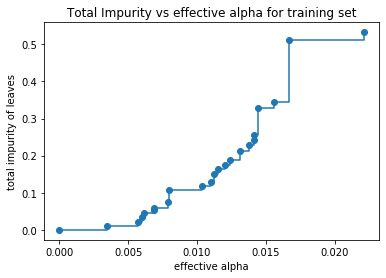

In [448]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [449]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.05927911697233923


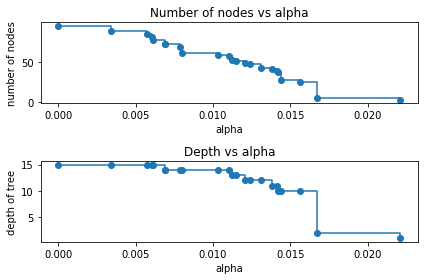

In [450]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

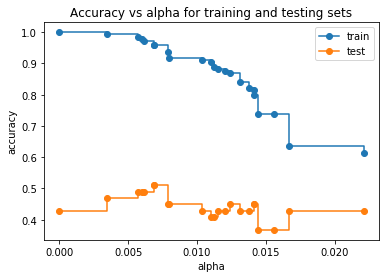

In [451]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

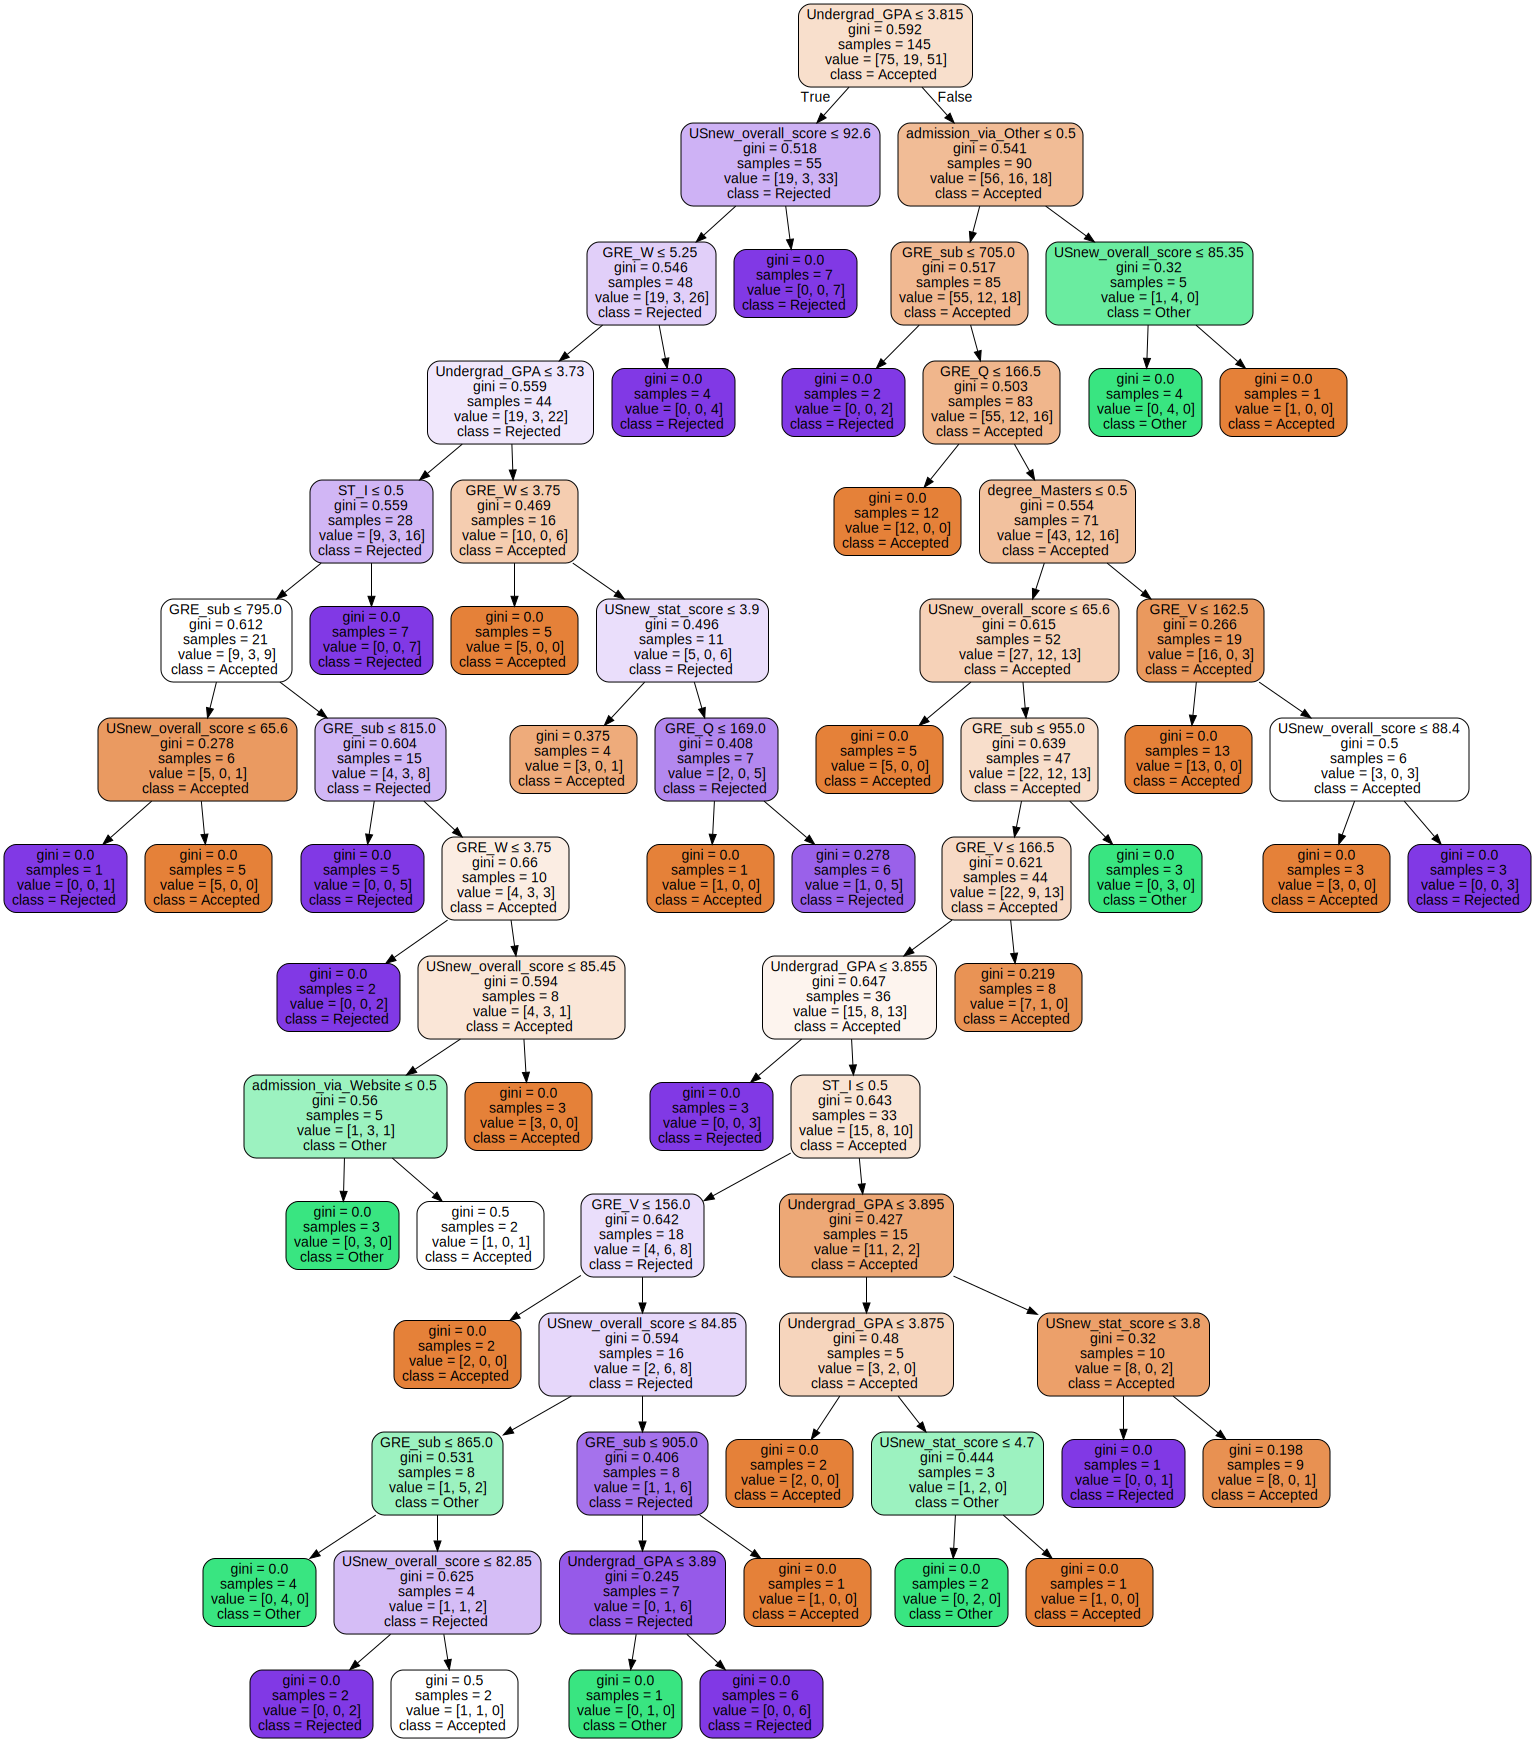

In [454]:
clfopt = clfs[np.argmax(test_scores)]
dot_data = tree.export_graphviz(clfopt, out_file=None,
                     feature_names=X.columns,
                     class_names=sorted(y.unique().tolist()),
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
# graph.render("status_tree")
graph

### Interpretation of result

Because of the large amount of missing data, the decision tree classifier does not perform very well in terms of prediction accuracy (0.51). Data imputation does not make sense in this case since almost all missing data happens in numerical variables such as GPA and GRE and missing is not random. We can neither impute randomly nor with other variables.

However, the classifier does provide some important interpretations towards graduate application (statistics). First, undergraduate GPA plays an essential role in graduate application (statistics). One needs to focus on his/her courses during undergraduate if he/she wants to apply for a competetive statistics graduate program. Second, GRE sub is important if undergraduate GPA is not competetive. Meanwhile, due to data limitation, we can not include other important factors, such as recommendation and undergraduate school, into our classifier, which may affect the performance of it.

## Predict admission status by Notes
Similarly, we can build a decision tree based on the notes left by the applicants. There is usually lots of information given in the notes, sometimes even more relevant and informative than quantitive variables like GPA.

We therefore raise an interesting question here: can we use notes only to predict one's admission status? This should make sense--sometimes we can tell one's result by simply looking at the notes he left.

20 Most Important Words:  ['please' 'funding' 'below' 'anyone' 'rejection' 'ta' 'sad' 'offer'
 'tuition' 'the' 'interview' 'to' 'excited' 'fellowship' 'from' 'rejected'
 'expected' 'check' 'wait' 'any']
10-fold Cross Validation Accuracy:  0.6663617916357338


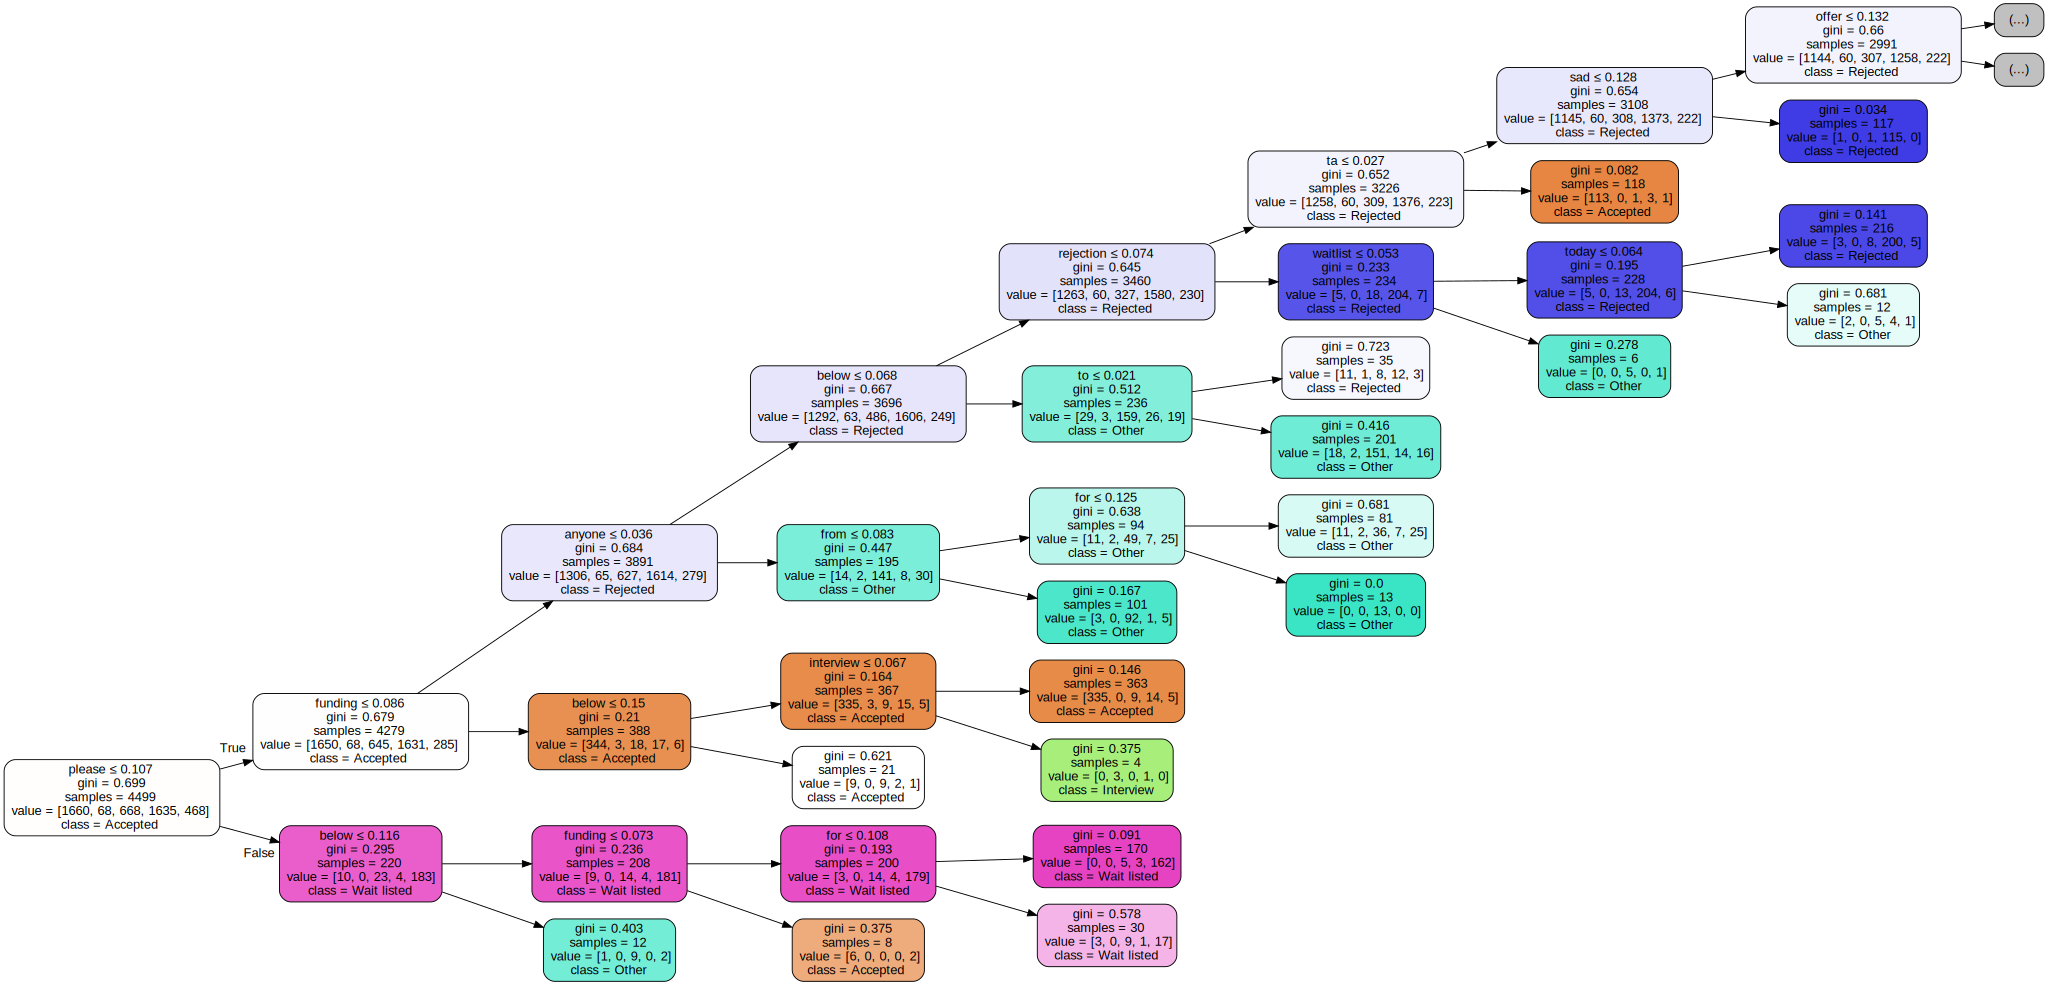

In [19]:
notes_decision_tree_classifier()

Although, as expected, the notes itself does not have much predicting power (CV accuracy: 0.66), the nodes on top of the tree are rather interesting. To our surprise, the most important nodes is "please". This actually makes sense. When someone says "please", he/she is very likely to be "Waitlisted"--he/she is urging those who are holding offers but not joining to decline as soon as possible.

In [20]:
for i in df["notes"].dropna()[lambda x: x.str.contains("please", case=False)].head(8):
    print(i)

'We do not rank our waitlist and cannot disclose how many people are listed on it.' 
Please decline early if you have better choices T.T Thank you so much!

'We do not rank our waitlist and cannot disclose how many people are listed on it.' 
Please decline early if you have better choices T.T Thank you so much!

On waitlist. If you decide not to go, please decline.
On waitlist. If you decide not to go, please decline.
Please decline as soon as possible if you are not going since the email said the status will update in two weeks.
For anyone who got accepted by M.A. Statistics but not going, please decline your offer. I really need this chance.
If you do not consider accepting this offer, please decline it ASAP. It is my only chance left. Thanks a lot.
Please decline ASAP if you have a better place to go. It’s really my dream school


The appearance of some other words on the tree also makes sense. For example, if one mentions "funding" or "TA" he is likely to be accepted, while the word "sad" always means one has been rejected.

## WorldCloud: What do applicants talk about most?
We generate and compare the WorldClouds generated by the notes of PhD and Master applicants, respectively.

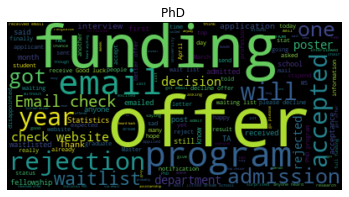

In [21]:
wordcloud_df({"degree": "PhD"})

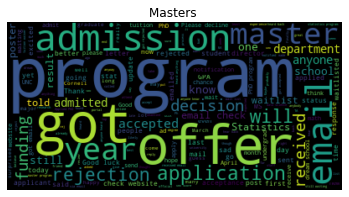

In [22]:
wordcloud_df({"degree": "Masters"})

The topics appearing in PhD and master applicants are very much alike. Interestingly, PhD applicants seems to care more about funding.

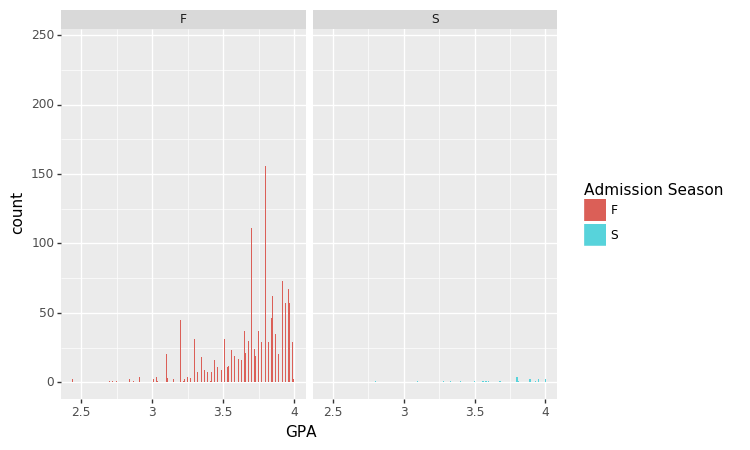

<ggplot: (-9223371944455300160)>

In [14]:
# GPA by season
df['fors'] = df.season.str[0:1]

gg = p9.ggplot(df.loc[(~pd.isna(df.Undergrad_GPA)), ], p9.aes(x='Undergrad_GPA', fill='fors'))
gg += p9.geom_col(stat='count') # add col geom
gg += p9.scale_fill_discrete(name='Admission Season')
gg += p9.facet_wrap('~fors')
gg += p9.labs(x = 'GPA')
gg

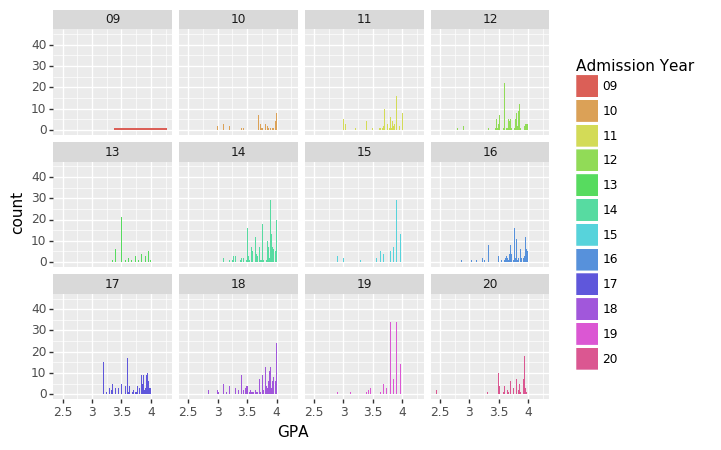

<ggplot: (-9223371944461561024)>

In [15]:
# GPA by year
df['year'] = df.season.str[1:]

gg = p9.ggplot(df.loc[(~pd.isna(df.Undergrad_GPA)), ], p9.aes(x='Undergrad_GPA', fill='factor(year)'))
gg += p9.geom_col(stat='count') # add col geom
gg += p9.scale_fill_discrete(name='Admission Year')
gg += p9.facet_wrap('~year')
gg += p9.labs(x = 'GPA')
gg

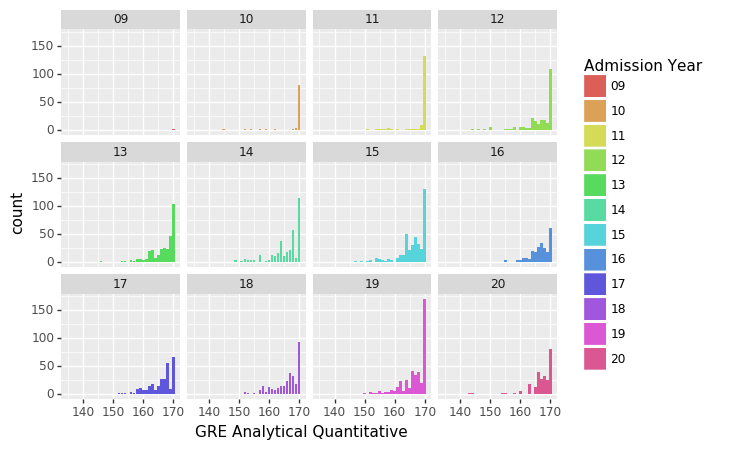

<ggplot: (-9223371944454770148)>

In [16]:
# GRE Q by year

gg = p9.ggplot(df.loc[(~pd.isna(df.GRE_Q)), ], p9.aes(x='GRE_Q', fill='factor(year)'))
gg += p9.geom_col(stat='count') # add col geom
gg += p9.scale_fill_discrete(name='Admission Year')
gg += p9.facet_wrap('~year')
gg += p9.labs(x = 'GRE Analytical Quantitative')
gg